# Objective:
    

Forecasting Sales is an essential use of Machine Learning(ML).Sales forecasts can be used to
identify benchmarks and determine incremental impacts of new initiatives, plan resources in response
to expected demand and project future budgets.
In this project I will do prediction of Rossmann Pharmaceuticals sales by considering different features and use ML and other 
statstical tools.

Data contains train, test and store data, where both train & test datasets are differ by variables Sales and Customers
which are target variables we need to consider.

Data field description:

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 
0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d
    
Assortment - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
    
CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



# Liberaries 

In [1]:
 #linear algebra and data processing
import numpy as np
import pandas as pd
import datetime

#visualisations
import seaborn as sb
import matplotlib.pyplot as plt


# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#ml
from sklearn.model_selection import train_test_split

# math and statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# ignnore warnings
import warnings
warnings.filterwarnings(action="ignore")


# Load Data sets

In [2]:
train_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\train.csv')


test_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\test.csv')

store_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\store.csv')

sample_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\sample_submission.csv')

In [3]:
print('train set shape:', train_data.shape)
print('test set shape:', test_data.shape)
print('store set shape:', store_data.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [85]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [86]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


6 of the store data columns contain missing values and one column of test data contain missing value.

In [7]:
#Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [8]:
missing_values_table(test_data)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Open,11,0.0,float64


In [9]:
missing_values_table(store_data)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,544,48.8,float64
Promo2SinceYear,544,48.8,float64
PromoInterval,544,48.8,object
CompetitionOpenSinceMonth,354,31.7,float64
CompetitionOpenSinceYear,354,31.7,float64
CompetitionDistance,3,0.3,float64


Before we deside to fill missing value we need to first merge both data sets with the store data.

In [10]:
# merge the train/test sets with the stores set
store_train = pd.merge(left = train_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
store_test = pd.merge(left = test_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
print(store_train.shape)
print(store_test.shape)


(1017209, 18)
(41088, 17)


# Data Preprocessing

In [11]:
#null values
store_train.isna().any()

Store                        False
DayOfWeek                    False
Date                         False
Sales                        False
Customers                    False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [87]:
store_train['Date']

0         1970-01-01 00:00:00.000000047
1         1970-01-01 00:00:00.000000046
2         1970-01-01 00:00:00.000000045
3         1970-01-01 00:00:00.000000044
4         1970-01-01 00:00:00.000000043
                       ...             
1017204                             NaT
1017205                             NaT
1017206                             NaT
1017207                             NaT
1017208                             NaT
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [12]:
#converting all non-numeric columns to numeric
store_train['Date']=store_train['Date'].astype('category').cat.codes
store_train['StateHoliday']=store_train['StateHoliday'].astype('category').cat.codes
store_train['StoreType']=store_train['StoreType'].astype('category').cat.codes
store_train['Assortment']=store_train['Assortment'].astype('category').cat.codes
store_train['PromoInterval']=store_train['PromoInterval'].astype('category').cat.codes
#store_test
store_test['Date']=store_test['Date'].astype('category').cat.codes
store_test['StateHoliday']=store_test['StateHoliday'].astype('category').cat.codes
store_test['StoreType']=store_test['StoreType'].astype('category').cat.codes
store_test['Assortment']=store_test['Assortment'].astype('category').cat.codes
store_test['PromoInterval']=store_test['PromoInterval'].astype('category').cat.codes

In [13]:
store_test.dtypes

Id                             int64
Store                          int64
DayOfWeek                      int64
Date                            int8
Open                         float64
Promo                          int64
StateHoliday                    int8
SchoolHoliday                  int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                   int8
dtype: object

In [14]:
#fill mising value
store_test['CompetitionDistance'].fillna(store_test['CompetitionDistance'].median(), inplace =True)
store_test.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_test.CompetitionOpenSinceYear.fillna(0,inplace=True)
store_test.Promo2SinceWeek.fillna(0, inplace = True)
store_test.Promo2SinceYear.fillna(0,inplace=True)
store_test.PromoInterval.fillna(0,inplace=True)
store_test.Open.fillna(0,inplace=True)

In [15]:
#fill mising value for store_train dataset
store_train['CompetitionDistance'].fillna(store_train['CompetitionDistance'].median(), inplace =True)
store_train.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_train.CompetitionOpenSinceYear.fillna(0,inplace=True)
store_train.Promo2SinceWeek.fillna(0, inplace = True)
store_train.Promo2SinceYear.fillna(0,inplace=True)
store_train.PromoInterval.fillna(0,inplace=True)

In [16]:
missing_values_table(store_train)
missing_values_table(store_test)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.
Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [17]:
store_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  int16  
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  int8   
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  int8   
 10  Assortment                 1017209 non-null  int8   
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [18]:
store_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  int8   
 4   Open                       41088 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  int8   
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  int8   
 9   Assortment                 41088 non-null  int8   
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  41088 non-null  float64
 12  CompetitionOpenSinceYear   41088 non-null  float64
 13  Promo2                     41088 non-null  int

In [19]:
def plotvar(df, variable):
    plt.subplot(1,2,2)
    sb.boxplot(df[variable])
    plt.show()

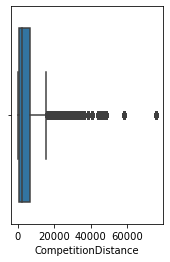

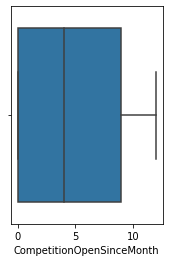

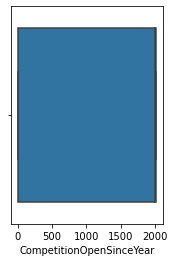

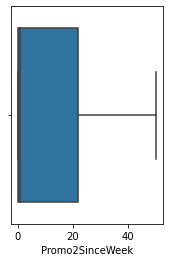

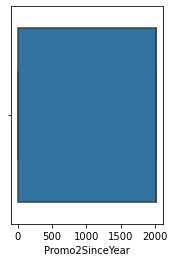

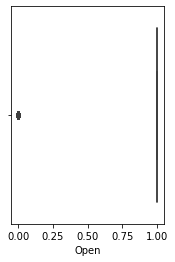

In [20]:
#outliers plot
plotvar(store_train,'CompetitionDistance')
plotvar(store_test,'CompetitionOpenSinceMonth')
plotvar(store_train,'CompetitionOpenSinceYear')
plotvar(store_train,'Promo2SinceWeek')
plotvar(store_train,'Promo2SinceYear')
plotvar(store_test,'Open')

In [21]:
def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]


In [22]:
#fix outliers
fix_outlier(store_train, 'CompetitionDistance')
fix_outlier(store_test, 'CompetitionDistance')

0        1270.0
1        1270.0
2        1270.0
3        1270.0
4        1270.0
          ...  
41083    5350.0
41084    5350.0
41085    5350.0
41086    5350.0
41087    5350.0
Name: CompetitionDistance, Length: 41088, dtype: float64

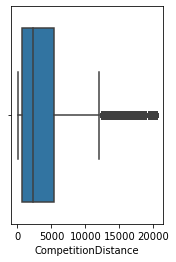

In [23]:
#plot after fixing outliers
plotvar(store_train,'CompetitionDistance')

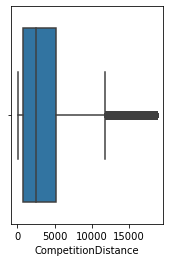

In [24]:
#plot after fix outliers
plotvar(store_test,'CompetitionDistance')

In [ ]:
x=

In [25]:
#extract neew feature from the existing datetime columns  
#change date column to datetime
store_train['Date'] = pd.to_datetime(store_train['Date'])
store_test['Date'] = pd.to_datetime(store_test['Date'])

In [26]:
store_train['Date'], store_test['Date']

(0         1970-01-01 00:00:00.000000941
 1         1970-01-01 00:00:00.000000940
 2         1970-01-01 00:00:00.000000939
 3         1970-01-01 00:00:00.000000938
 4         1970-01-01 00:00:00.000000937
                        ...             
 1017204   1970-01-01 00:00:00.000000004
 1017205   1970-01-01 00:00:00.000000003
 1017206   1970-01-01 00:00:00.000000002
 1017207   1970-01-01 00:00:00.000000001
 1017208   1970-01-01 00:00:00.000000000
 Name: Date, Length: 1017209, dtype: datetime64[ns],
 0       1970-01-01 00:00:00.000000047
 1       1970-01-01 00:00:00.000000046
 2       1970-01-01 00:00:00.000000045
 3       1970-01-01 00:00:00.000000044
 4       1970-01-01 00:00:00.000000043
                      ...             
 41083   1970-01-01 00:00:00.000000004
 41084   1970-01-01 00:00:00.000000003
 41085   1970-01-01 00:00:00.000000002
 41086   1970-01-01 00:00:00.000000001
 41087   1970-01-01 00:00:00.000000000
 Name: Date, Length: 41088, dtype: datetime64[ns])

In [27]:
store_test['Date'] = pd.to_datetime(store_test['Date'])

In [28]:
store_train['Date'] = pd.to_datetime(store_test['Date'])

In [29]:
store_test['weekdays']=store_test['Date'].dt.week

In [30]:
store_test['weekdays'].unique()

array([1], dtype=int64)

In [31]:
store_train['weekdays']=store_train['Date'].dt.week

In [32]:
store_train['weekdays'].unique()

array([ 1., nan])

In [33]:
def feature_generation(data):
    data['Date'] = pd.to_datetime(data.Date)
    data['Month'] = data.Date.dt.month.to_list()
    data['Year'] = data.Date.dt.year.to_list()
    data['Day'] = data.Date.dt.day.to_list()
    data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
    data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
    data['weekday'] = 1 # Initialize the column with default value of 1
    data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
    data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0
    data = data.drop(['Date'], axis = 1)
    return data


In [34]:
features=feature_generation(store_train)

In [35]:
feature_generation(store_test)

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekdays,Month,Year,Day,WeekOfYear,weekday
0,1,1,3,1.0,1,0,0,2,0,1270.0,...,0,0.0,0.0,-1,1,1,1970,1,1,1
1,857,1,3,1.0,1,0,0,2,0,1270.0,...,0,0.0,0.0,-1,1,1,1970,1,1,1
2,1713,1,3,1.0,1,0,0,2,0,1270.0,...,0,0.0,0.0,-1,1,1,1970,1,1,1
3,2569,1,3,1.0,1,0,0,2,0,1270.0,...,0,0.0,0.0,-1,1,1,1970,1,1,1
4,3425,1,3,0.0,0,0,0,2,0,1270.0,...,0,0.0,0.0,-1,1,1,1970,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,1.0,1,0,1,3,2,5350.0,...,1,22.0,2012.0,2,1,1,1970,1,1,1
41084,38520,1115,3,1.0,1,0,1,3,2,5350.0,...,1,22.0,2012.0,2,1,1,1970,1,1,1
41085,39376,1115,3,1.0,1,0,1,3,2,5350.0,...,1,22.0,2012.0,2,1,1,1970,1,1,1
41086,40232,1115,3,0.0,0,0,1,3,2,5350.0,...,1,22.0,2012.0,2,1,1,1970,1,1,1


In [36]:
train_features = feature_generation(store_train)
test_features = feature_generation(store_test)

In [37]:
# train_features.dtypes
test_features.dtypes 

Id                             int64
Store                          int64
DayOfWeek                      int64
Open                         float64
Promo                          int64
StateHoliday                    int8
SchoolHoliday                  int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                   int8
weekdays                       int64
Month                          int64
Year                           int64
Day                            int64
WeekOfYear                     int64
weekday                        int64
dtype: object

# number of days to holidays
- Number of days after holiday
- Beginning of month, mid month and ending of month?????????????

In [54]:
#identify weekends
store_train['is_weekend'] = ((pd.DatetimeIndex(store_train['Date']).dayofweek) // 5 == 1).astype(int)
store_train.head(14)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekdays,Month,Year,Day,WeekOfYear,weekday,is_weekend
0,1,3.0,1970-01-01 00:00:00.000000047,5263,555,1,1,1,1,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
1,1,3.0,1970-01-01 00:00:00.000000046,5020,546,1,1,1,1,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
2,1,3.0,1970-01-01 00:00:00.000000045,4782,523,1,1,1,1,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
3,1,3.0,1970-01-01 00:00:00.000000044,5011,560,1,1,1,1,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
4,1,3.0,1970-01-01 00:00:00.000000043,6102,612,1,1,1,1,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
5,1,3.0,1970-01-01 00:00:00.000000042,0,0,0,0,1,0,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
6,1,3.0,1970-01-01 00:00:00.000000041,4364,500,1,0,1,0,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
7,1,3.0,1970-01-01 00:00:00.000000040,3706,459,1,0,1,0,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
8,1,3.0,1970-01-01 00:00:00.000000039,3769,503,1,0,1,0,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0
9,1,3.0,1970-01-01 00:00:00.000000038,3464,463,1,0,1,0,2,...,0.0,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0


In [58]:
#identify each holiday
store_train['is_holiday'] = np.where(store_train['Date'].isin(store_train['StateHoliday']), 1, 0)
store_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,weekdays,Month,Year,Day,WeekOfYear,weekday,is_weekend,is_holiday
0,1,3.0,1970-01-01 00:00:00.000000047,5263,555,1,1,1,1,2,...,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0
1,1,3.0,1970-01-01 00:00:00.000000046,5020,546,1,1,1,1,2,...,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0
2,1,3.0,1970-01-01 00:00:00.000000045,4782,523,1,1,1,1,2,...,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0
3,1,3.0,1970-01-01 00:00:00.000000044,5011,560,1,1,1,1,2,...,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0
4,1,3.0,1970-01-01 00:00:00.000000043,6102,612,1,1,1,1,2,...,0.0,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0


In [59]:
#identify working day
store_train['is_working_day'] = np.where((store_train['is_weekend']==1) | (store_train['is_holiday']==1), 0, 1)
store_train.head(14)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,weekdays,Month,Year,Day,WeekOfYear,weekday,is_weekend,is_holiday,is_working_day
0,1,3.0,1970-01-01 00:00:00.000000047,5263,555,1,1,1,1,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
1,1,3.0,1970-01-01 00:00:00.000000046,5020,546,1,1,1,1,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
2,1,3.0,1970-01-01 00:00:00.000000045,4782,523,1,1,1,1,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
3,1,3.0,1970-01-01 00:00:00.000000044,5011,560,1,1,1,1,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
4,1,3.0,1970-01-01 00:00:00.000000043,6102,612,1,1,1,1,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
5,1,3.0,1970-01-01 00:00:00.000000042,0,0,0,0,1,0,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
6,1,3.0,1970-01-01 00:00:00.000000041,4364,500,1,0,1,0,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
7,1,3.0,1970-01-01 00:00:00.000000040,3706,459,1,0,1,0,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
8,1,3.0,1970-01-01 00:00:00.000000039,3769,503,1,0,1,0,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1
9,1,3.0,1970-01-01 00:00:00.000000038,3464,463,1,0,1,0,2,...,-1,1.0,1.0,1970.0,1.0,1.0,1,0,0,1


In [80]:
#number of days after holiday
store_train['Date'].max()

Timestamp('1970-01-01 00:00:00.000000047')

# scale the data

In [121]:
#Adding salespercustomer column
store_train['SalesperCustomer']=store_train['Sales']/store_train['Customers']

In [122]:
store_train.dtypes

DayOfWeek                           float64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                           int8
SchoolHoliday                         int64
StoreType                              int8
Assortment                             int8
CompetitionDistance                 float64
CompetitionOpenSinceMonth             Int64
CompetitionOpenSinceYear              Int64
Promo2                                int64
Promo2SinceWeek                       Int64
Promo2SinceYear                       Int64
PromoInterval                          int8
weekdays                            float64
Month                               float64
Year                                float64
Day                                 float64
WeekOfYear                          float64
weekday                         

In [152]:
# change dtypes for uniformity in preprocessing
features.DayOfWeek = features.DayOfWeek.astype('Int64')
featuresCompetitionDistance = features.CompetitionDistance .astype('Int64')
features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64')
features.weekdays = features.weekdays.astype('Int64') 
features.Month   = features.Month  .astype('Int64') 
features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
features["StateHoliday"].loc[features["StateHoliday"] == 0] = 0
features.Year = features.Year.astype('Int64')
features.Day = features.Day.astype('Int64')
features.WeekOfYear = features.WeekOfYear.astype('Int64')
#features.Date = features.Date.astype('Int64')                 

#features = features.drop(['Store'], axis = 1)

In [144]:
features.dtypes

DayOfWeek                      Int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                    int8
SchoolHoliday                  int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth      Int64
CompetitionOpenSinceYear       Int64
Promo2                         int64
Promo2SinceWeek                Int64
Promo2SinceYear                Int64
PromoInterval                   int8
weekdays                       Int64
Month                          Int64
Year                           Int64
Day                            Int64
WeekOfYear                     Int64
weekday                        int64
SalesperCustomer             float64
dtype: object

# Building models with sklearn pipelines

In [145]:
#corrilatin analysis
store_train.corr()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,weekdays,Month,Year,Day,WeekOfYear,weekday,SalesperCustomer
DayOfWeek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sales,NaN,1.000000,0.894711,0.678472,0.452345,-0.140730,0.085124,-0.013057,0.074941,-0.037019,...,-0.044143,-0.091056,-0.085688,NaN,NaN,NaN,NaN,NaN,NaN,0.186581
Customers,NaN,0.894711,1.000000,0.616768,0.316169,-0.133735,0.071568,-0.141423,0.007044,-0.166354,...,-0.098323,-0.150138,-0.136527,NaN,NaN,NaN,NaN,NaN,NaN,-0.323898
Open,NaN,0.678472,0.616768,1.000000,0.295042,-0.233225,0.086171,-0.003325,0.002972,-0.004399,...,-0.007436,-0.008308,-0.007174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Promo,NaN,0.452345,0.316169,0.295042,1.000000,-0.013444,0.067483,-0.000299,0.000294,-0.000027,...,-0.001210,-0.000983,-0.000879,NaN,NaN,NaN,NaN,NaN,NaN,0.280009
StateHoliday,NaN,-0.140730,-0.133735,-0.233225,-0.013444,1.000000,0.085372,0.004737,-0.004850,0.000972,...,0.018727,0.015918,0.014095,NaN,NaN,NaN,NaN,NaN,NaN,0.028506
SchoolHoliday,NaN,0.085124,0.071568,0.086171,0.067483,0.085372,1.000000,0.000032,-0.002530,-0.000744,...,-0.006679,-0.006912,-0.006474,NaN,NaN,NaN,NaN,NaN,NaN,0.013192
StoreType,NaN,-0.013057,-0.141423,-0.003325,-0.000299,0.004737,0.000032,1.000000,0.232862,0.281056,...,0.059704,0.088865,0.088642,NaN,NaN,NaN,NaN,NaN,NaN,0.443258
Assortment,NaN,0.074941,0.007044,0.002972,0.000294,-0.004850,-0.002530,0.232862,1.000000,0.173881,...,-0.030182,0.008267,0.039619,NaN,NaN,NaN,NaN,NaN,NaN,0.198952
CompetitionDistance,NaN,-0.037019,-0.166354,-0.004399,-0.000027,0.000972,-0.000744,0.281056,0.173881,1.000000,...,-0.016953,-0.017361,-0.033978,NaN,NaN,NaN,NaN,NaN,NaN,0.389707


# Defining independent and dependent variables
- let independent/Features = X
- let dependent/Target = Y

We want to predict store sales, the target dependent variable is sales. For features we
remove all columns that are strongly correlated to sales. From correlation analysis, we see that
"customers","Open","Promo" and "salespercustomer" have a strong positive correlation with sale. There we do
away with these columns.

In [146]:
X = store_train.drop(['Customers','Open','Promo', 'Sales','SalesperCustomer'], axis = 1)

In [147]:
y=store_train['Sales']

In [148]:
#Training and testing split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [149]:
X_train.size, X_test.size, y_train.size, y_test.size

(15461573, 3865398, 813767, 203442)

In [150]:
#Feature Scaling
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [float64]